In [3]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [5]:
if 0:
    sys.path.insert(0,os.getcwd()+"/../../src/main")
else:
    sys.path.insert(0, "/mnt/lanlep2019/src/main")
    os.environ['LOCAL']="/mnt/local"

In [6]:
!echo $LOCAL

/mnt/local


In [7]:
!mkdir -p $LOCAL/sandbox

In [8]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/mnt/local/sandbox'

In [10]:
os.environ['LANLEP_HOME']=HOME

In [11]:
import data

In [14]:
if 0:
    !ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/
else:
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmp.tar | tar xf - 
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmppkl.tar | tar xf -     

In [17]:
reload (data)

<module 'data' from '/mnt/lanlep2019/src/main/data.py'>

In [18]:
if 1:
    strategy = {'type':'rand', "fold":5}
    types=['fwv']
    traintest = data.TrainTest('offset', offset=0, types=types, transform=None, valid_strategy=strategy)

In [19]:
traintest.num_dataset()

5

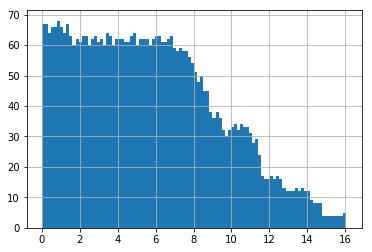

In [20]:
traintest.ydf.hist(bins=100);

In [21]:
np.abs(traintest.ydf-traintest.ydf.median()).mean()

3.032763197384022

In [50]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 100)

In [51]:
traindf=traintest.traindf
ydf=traintest.ydf
qdf=traindf.index.map(lambda u: int(u.split("_")[1]))

In [52]:
idx=~qdf.isin({0,16})
traindf=traindf[idx]
ydf=ydf[idx]
qdf=qdf[idx]

In [53]:
if 0:
    idx=ydf<10
    traindf=traindf[idx]
    ydf=ydf[idx]
    qdf=qdf[idx]
else:
    ydf[ydf>10]=10

In [54]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [55]:
colors= [
        "FF0000", "00FF00", "0000FF", "FF00FF", "00FFFF", "000000", 
        "800000", "008000", "000080", "808000", "800080", "008080", "808080", 
        "C00000", "00C000", "0000C0", "C0C000", "C000C0", "00C0C0", "C0C0C0", 
        "400000", "004000", "000040", "404000", "400040", "004040", "404040", 
        "200000", "002000", "000020", "202000", "200020", "002020", "202020", 
        "600000", "006000", "000060", "606000", "600060", "006060", "606060", 
        "A00000", "00A000", "0000A0", "A0A000", "A000A0", "00A0A0", "A0A0A0", 
        "E00000", "00E000", "0000E0", "E0E000", "E000E0", "00E0E0", "E0E0E0", 
    ]
colors=[np.array([int(h[i:i+2], 16)/255.0 for i in (0, 2 ,4)]) for h in colors]

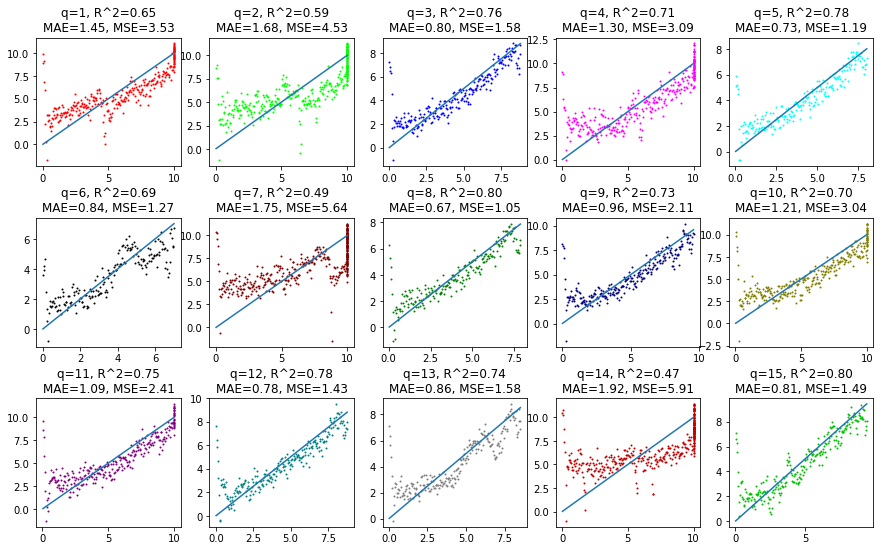

In [56]:
fig, axs = plt.subplots(figsize=(15,9), 
                        nrows=3, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

references=range(1,16)

for ax, (i,qno) in zip(axs.flatten(), enumerate(references)):
    X=traindf[qdf==qno]
    Y=ydf[qdf==qno]
    reg = Ridge().fit(X,Y)
    x,y=Y,reg.predict(X)
    ax.scatter(x,y,s=1,c=colors[i])
    b=sorted(x.values)
    ax.plot(b,b)
    ax.set_title('q={}, R^2={:.2f}\nMAE={:.2f}, MSE={:.2f}'.format(qno,r2_score(x,y), mean_absolute_error(x,y)
                                                                   ,mean_squared_error(x,y)))
    

In [57]:
#! cd /mnt && tar xf /mnt/lizhen-east2/notebook/fastseq/5/trainqs.tar

In [58]:
def readq(qno):
    return fastparquet.ParquetFile("/mnt/quake_{}.parq".format(qno)).to_pandas()

In [59]:
reg = LinearRegression().fit(traindf, ydf)

In [60]:
reg.score(traindf,ydf)

0.48467214705353195

In [61]:
trainpred=reg.predict(traindf)

In [62]:
err=ydf.values-trainpred
np.sqrt(np.mean(err*err)),np.sqrt(np.median(np.abs(err)))

(2.2479487922477848, 1.2295255891294152)

In [63]:
a=ydf.copy().to_frame()
a['pred']=trainpred
a['abserr']=np.abs(a['pred']-a['y'])
a['qno']=a.index.map(lambda u: int(u.split("_")[1]))

In [64]:
a.groupby('qno')['abserr'].apply(lambda u: np.sqrt(np.mean(u.values**2))).sort_values()

qno
9     1.562609
11    1.663820
3     1.664309
12    1.691627
15    1.802795
10    1.837165
13    1.892169
1     1.919248
4     2.205253
5     2.325665
8     2.351410
6     2.598147
2     2.602109
14    2.904742
7     3.004695
Name: abserr, dtype: float64

In [65]:
a.groupby('qno')['abserr'].apply(lambda u:  np.mean(u.values)).sort_values()

qno
9     1.052469
3     1.209473
12    1.258950
11    1.310064
15    1.319357
13    1.457062
10    1.476009
1     1.587658
4     1.859251
5     1.977884
8     2.094604
2     2.114797
6     2.271694
7     2.447738
14    2.450083
Name: abserr, dtype: float64

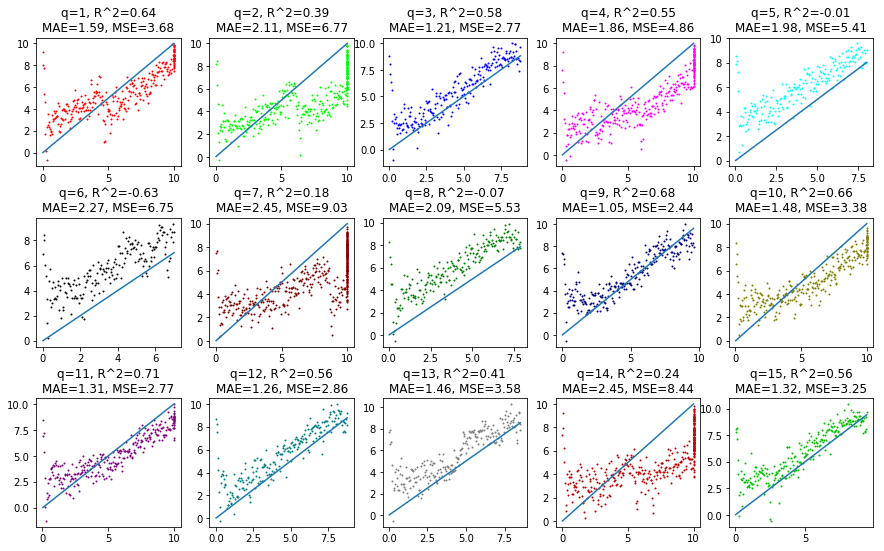

In [66]:
fig, axs = plt.subplots(figsize=(15,9), 
                        nrows=3, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

references=sorted(set(a['qno']))

for ax, (i,qno) in zip(axs.flatten(), enumerate(references)):
    x,y=a[a['qno']==qno]['y'],a[a['qno']==qno]['pred']
    ax.scatter(x,y,s=1,c=colors[i])
    b=sorted(x.values)
    ax.plot(b,b)
    ax.set_title('q={}, R^2={:.2f}\nMAE={:.2f}, MSE={:.2f}'.format(qno,r2_score(x,y), mean_absolute_error(x,y)
                                                                   ,mean_squared_error(x,y)))
    

5.439392 5.0970984


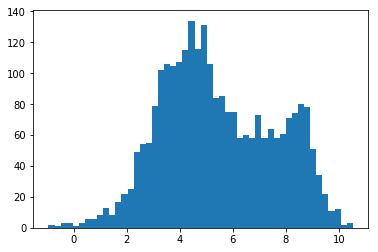

In [67]:
pred = reg.predict(testdf)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [68]:
!mkdir -p /mnt/local/input/sub/

In [69]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_lr_gt10to10.csv",index=None)

(2624, 2)
